[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dgomes03/FIRE-HACK-Project/blob/main/RFR_model.ipynb)

In [38]:
import pandas as pd
import numpy as np
import warnings
import geopandas as gpd
from dbfread import DBF
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

### Load data

In [39]:
print("Loading dataset...")

try:
    shp_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model.shp'
    df = gpd.read_file(shp_path)
    print("Dataset loaded")

except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

Loading dataset...
Dataset loaded


### remove nans from ros_p

In [40]:
# Remove rows where 'ros_p' is NaN
n_before = len(df)
df = df.dropna(subset=['ros_p']).reset_index(drop=True)
n_after = len(df)
print(f"Removed {n_before - n_after} rows with NaN in 'ros_p'. Remaining rows: {n_after}")

Removed 4 rows with NaN in 'ros_p'. Remaining rows: 1355


### Turn ros lags into log

In [41]:
# Identify only ros_p lag columns

log_base = 4.9867

ros_lag_cols = [col for col in df.columns if col.startswith('ros_p_lg')]

# Apply log transformation only to ros_p lag columns
for col in ros_lag_cols:
    log_col = f'{col}_log'
    df[log_col] = np.where(
        df[col] > 0,
        np.log1p(df[col]) / np.log(log_base),
        np.nan
    )

df.drop(columns=ros_lag_cols, inplace=True)

In [42]:
print(df)

          inidoy      enddoy        ros_p  duration_p  1_3y_fir_p  3_8y_fir_p  \
0     221.750000  221.958333  1199.641053    5.000000    0.000000    0.000000   
1     221.958333  222.125000   397.497644    4.000000    0.000000    0.000000   
2     222.500000  222.604167  1092.753836    2.500000    0.000000    0.000000   
3     222.604167  222.916667   584.937417    7.500000    0.000000    0.000000   
4     241.722222  241.784722   708.321556    1.500000    0.000000    0.000000   
...          ...         ...          ...         ...         ...         ...   
1350  245.784722  245.895833   341.431246    2.666667    0.000000  100.000000   
1351  245.784722  246.041667   528.492172    6.166667    0.651997    9.698452   
1352  246.041667  246.250000    44.428880    5.000000    0.000000    0.000000   
1353  246.625000  246.701389   426.952064    1.833333    0.000000   98.989899   
1354  246.701389  246.770833   234.468394    1.666667    0.000000   62.745098   

      8_ny_fir_p     elev_a

### Create test and train datasets

In [43]:
# -----------------------------------------
# Random 80/20 Train-Test Split
# -----------------------------------------

df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

# Reset indices
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# -----------------------------------------
# Features and Target
# -----------------------------------------

train_features = [col for col in df.columns if col not in ('ros_p', 'inidoy', 'enddoy', "geometry")]

# Define X and y for both splits
X_train = df_train[train_features].copy()
X_test = df_test[train_features].copy()
y_train = df_train['ros_p'].copy()
y_test = df_test['ros_p'].copy()

# -----------------------------------------
# Summary
# -----------------------------------------
print("Training set size:", len(X_train))
print("Test set size:", len(X_test))

# -----------------------------------------
# Prepare feature and target DataFrames
# -----------------------------------------

# Remove invalid targets (-1 values)
valid_train = y_train != -1
valid_test = y_test != -1

X_train_final = X_train[valid_train].reset_index(drop=True)
y_train_final = y_train[valid_train].reset_index(drop=True)

X_test_final = X_test[valid_test].reset_index(drop=True)
y_test_final = y_test[valid_test].reset_index(drop=True)

print(f"\nRows removed due to invalid target (-1):")
print(f"  Train: {(~valid_train).sum()} rows removed, {len(X_train_final)} final rows")
print(f"  Test: {(~valid_test).sum()} rows removed, {len(X_test_final)} final rows")

# Verify no NaN values remain
print(f"\nFinal verification - NaN values remaining:")
print(f"  X_train_final: {X_train_final.isna().sum().sum()}")
print(f"  X_test_final: {X_test_final.isna().sum().sum()}")
print(f"  y_train_final: {pd.isna(y_train_final).sum()}")
print(f"  y_test_final: {pd.isna(y_test_final).sum()}")

# Save datasets
#X_train_final.to_csv('X_train_with_lags.csv', index=False)
#y_train_final.to_csv('y_train_with_lags.csv', index=False)
#X_test_final.to_csv('X_test_with_lags.csv', index=False)  
#y_test_final.to_csv('y_test_with_lags.csv', index=False)

Training set size: 1084
Test set size: 271

Rows removed due to invalid target (-1):
  Train: 0 rows removed, 1084 final rows
  Test: 0 rows removed, 271 final rows

Final verification - NaN values remaining:
  X_train_final: 4282
  X_test_final: 1097
  y_train_final: 0
  y_test_final: 0


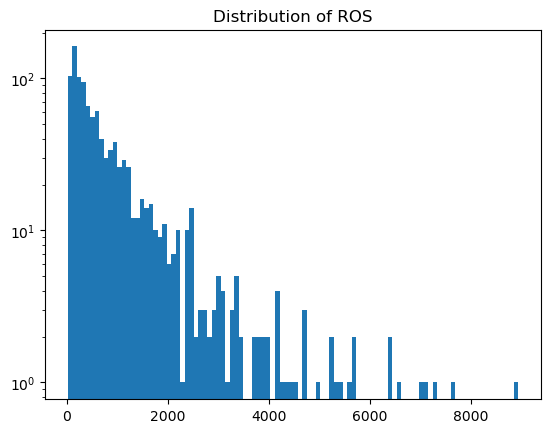

In [44]:
# Plot distribution of y_train_final (ros_p)
plt.hist(y_train_final, bins=100)
plt.yscale('log')
plt.title("Distribution of ROS")
plt.show()

### XGBoost

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 200
max_resources_: 2000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 200
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 1
n_candidates: 4
n_resources: 600
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 1800
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Search complete.
Best parameters found: {'colsample_bytree': np.float64(0.7173952698872152), 'gamma': np.float64(0.007039911357542228), 'learning_rate': np.float64(0.0676642971857535), 'max_depth': 7, 'min_child_weight': 3, 'reg_alpha': np.float64(0.7712703466859457), 'reg_lambda': np.float64(1.1480893034681807), 'subsample': np.float64(0.7433862914177091), 'n_estimators': 1800}

Log scale metrics:
R2 Score (log): 0.6341
RMSE (log): 0.3915 (linear: 645.8)
MAE (log): 0.3042 (linear: 373.2)


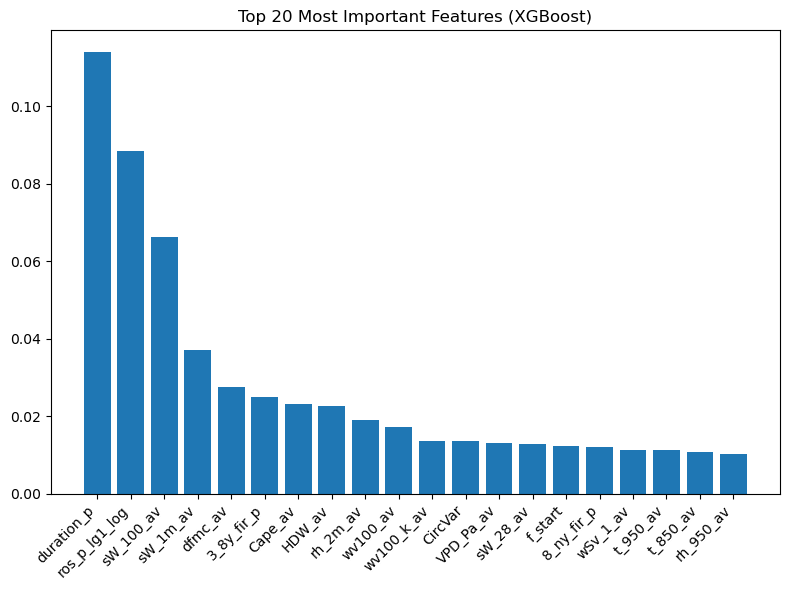


Top 20 Most Important Features:
          feature  importance
0      duration_p    0.113952
94  ros_p_lg1_log    0.088444
20      sW_100_av    0.066322
33       sW_1m_av    0.037217
32        dfmc_av    0.027474
2      3_8y_fir_p    0.025010
16        Cape_av    0.023150
37         HDW_av    0.022797
30       rh_2m_av    0.019117
89       wv100_av    0.017363
28     wv100_k_av    0.013713
92        CircVar    0.013652
31      VPD_Pa_av    0.013202
19       sW_28_av    0.012963
93        f_start    0.012395
3      8_ny_fir_p    0.011979
45       wSv_1_av    0.011302
68       t_950_av    0.011252
69       t_850_av    0.010941
63      rh_950_av    0.010318


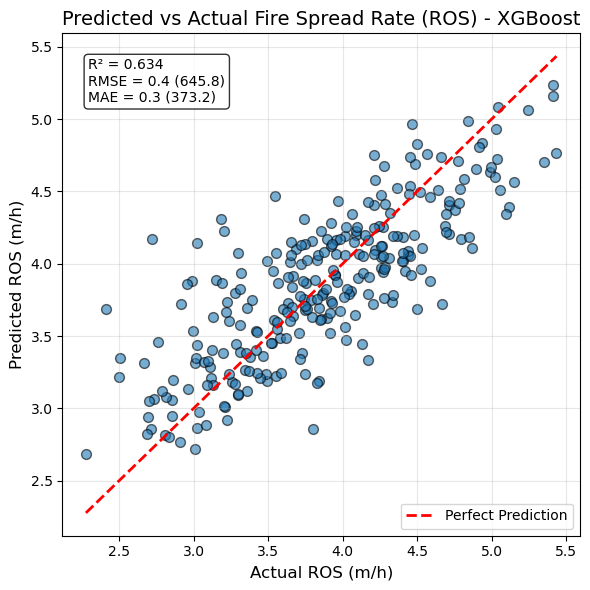

In [45]:
import xgboost as xgb
from scipy.stats import randint, uniform

log_base = 4.9867

# Transform ros_p to log
y_train_log = np.log1p(y_train_final) / np.log(log_base)
y_test_log = np.log1p(y_test_final) / np.log(log_base)

# XGBoost parameter distributions
param_dist = {
    'max_depth': [3, 5, 7, 9, 11],                    # tree depth
    'learning_rate': uniform(0.01, 0.29),             # eta: step size shrinkage (0.01-0.3)
    'subsample': uniform(0.6, 0.4),                   # row sampling (0.6-1.0)
    'colsample_bytree': uniform(0.6, 0.4),            # column sampling per tree (0.6-1.0)
    'min_child_weight': randint(1, 10),               # minimum sum of instance weight in a child
    'gamma': uniform(0, 0.5),                         # minimum loss reduction for split
    'reg_alpha': uniform(0, 1),                       # L1 regularization
    'reg_lambda': uniform(1, 2),                      # L2 regularization
}

# Base XGBoost model
base_model = xgb.XGBRegressor(
    n_jobs=-1, 
    random_state=42,
    objective='reg:squarederror',
    tree_method='hist'  # faster histogram-based algorithm
)

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Halving random search
xgb_random = HalvingRandomSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    factor=3,                    # how aggressively to cut poor performers
    resource='n_estimators',
    max_resources=2000,
    min_resources=200,
    scoring='r2',
    cv=tscv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Train the model search
xgb_random.fit(X_train_final, y_train_log)

# Get the best model and parameters
print(f"\nSearch complete.")
print(f"Best parameters found: {xgb_random.best_params_}")
best_model = xgb_random.best_estimator_

# Make predictions with the best model
y_pred_log = best_model.predict(X_test_final)
y_pred = np.expm1(y_pred_log)

# Inverse transform log to linear
y_test_linear = (log_base ** y_test_log) - 1
y_pred_linear = (log_base ** y_pred_log) - 1

# Metrics in log space
r2 = r2_score(y_test_log, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
mae_log = mean_absolute_error(y_test_log, y_pred_log)

# Metrics in linear space
rmse_linear = np.sqrt(mean_squared_error(y_test_linear, y_pred_linear))
mae_linear = mean_absolute_error(y_test_linear, y_pred_linear)

# Feature importance
feature_names = X_train_final.columns.tolist()
importances = pd.DataFrame({
    'feature': feature_names,
    'importance': best_model.feature_importances_
})
importances = importances.sort_values('importance', ascending=False)

print("\nLog scale metrics:")
print(f"R2 Score (log): {r2:.4f}")
print(f"RMSE (log): {rmse_log:.4f} (linear: {rmse_linear:.1f})")
print(f"MAE (log): {mae_log:.4f} (linear: {mae_linear:.1f})")

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.bar(importances['feature'][:20], importances['importance'][:20])
plt.xticks(rotation=45, ha='right')
plt.title(f'Top 20 Most Important Features (XGBoost)')
plt.tight_layout()
plt.show()
print("\nTop 20 Most Important Features:")
print(importances.head(20))

# Predicted vs Actual scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test_log, y_pred_log, alpha=0.6, edgecolor='k', s=50)

# Perfect prediction line
min_val = min(y_test_log.min(), y_pred_log.min())
max_val = max(y_test_log.max(), y_pred_log.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title('Predicted vs Actual Fire Spread Rate (ROS) - XGBoost', fontsize=14)
plt.xlabel('Actual ROS (m/h)', fontsize=12)
plt.ylabel('Predicted ROS (m/h)', fontsize=12)

# Add metrics annotation with both log and linear scales
plt.text(0.05, 0.95, 
         f'R² = {r2:.3f}\n'
         f'RMSE = {rmse_log:.1f} ({rmse_linear:.1f})\n'
         f'MAE = {mae_log:.1f} ({mae_linear:.1f})', 
         transform=plt.gca().transAxes, 
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

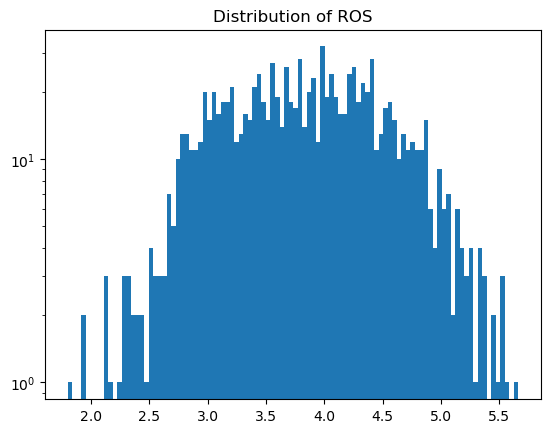

In [46]:
# Plot distribution of y_train_final (ros_p)
plt.hist(y_train_log, bins=100)
plt.yscale('log')
plt.title("Distribution of ROS")
plt.show()

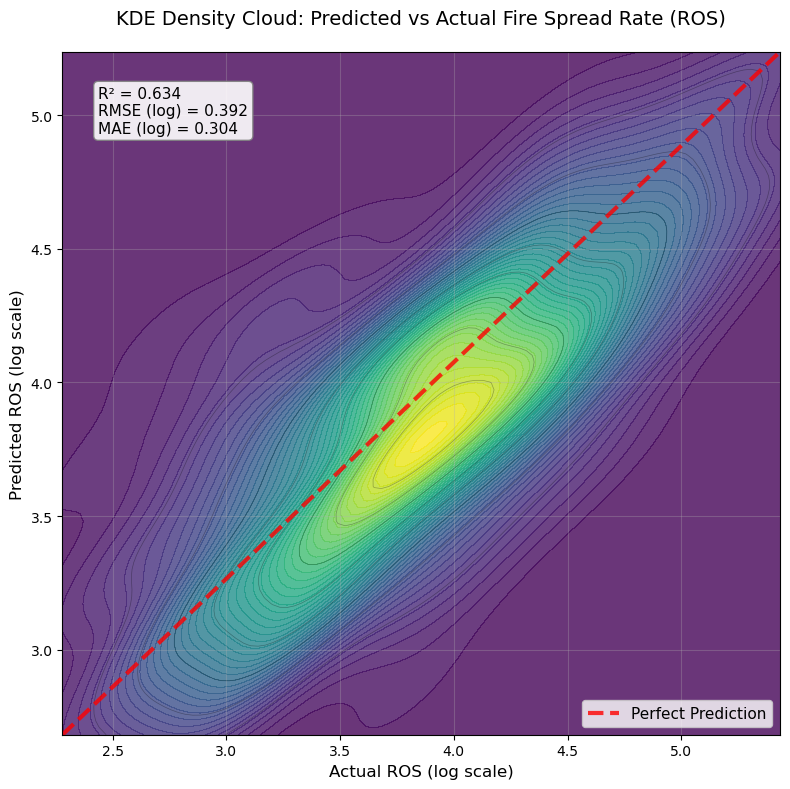

In [47]:
# KDE Density cloud plot (no dots)
plt.figure(figsize=(8, 8))

# Create KDE density plot
from scipy.stats import gaussian_kde
import numpy as np

# Calculate the point density
x = y_test_log
y = y_pred_log
xy = np.vstack([x, y])

# Create meshgrid for density plot
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Calculate KDE on the grid
kde = gaussian_kde(xy)
z = np.reshape(kde(positions).T, xx.shape)

# Plot filled contour (density cloud)
plt.contourf(xx, yy, z, levels=50, cmap='viridis', alpha=0.8)

# Add contour lines for better definition
plt.contour(xx, yy, z, levels=10, colors='black', alpha=0.3, linewidths=0.5)

# Perfect prediction line
plt.plot([xmin, xmax], [ymin, ymax], 'r--', linewidth=3, label='Perfect Prediction', alpha=0.8)

plt.title('KDE Density Cloud: Predicted vs Actual Fire Spread Rate (ROS)', fontsize=14, pad=20)
plt.xlabel('Actual ROS (log scale)', fontsize=12)
plt.ylabel('Predicted ROS (log scale)', fontsize=12)

# Add metrics annotation
plt.text(0.05, 0.95, 
         f'R² = {r2:.3f}\n'
         f'RMSE (log) = {rmse_log:.3f}\n'
         f'MAE (log) = {mae_log:.3f}', 
         transform=plt.gca().transAxes,
         fontsize=11,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))

plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### log parameter c finder

In [11]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from itertools import product

class LogTransformOptimizer:
    """
    Optimizes transformation parameters for:
    1. log_c(y + 1) - finds optimal base c
    2. x*log(y + 1) - finds optimal multiplier x
    Now searches both parameters simultaneously
    """
    
    def __init__(self, X_train, y_train, X_test, y_test, 
                 param_dist=None, cv_splits=5, verbose=True):
        """
        Initialize the optimizer.
        
        Parameters:
        -----------
        X_train, y_train : Training data
        X_test, y_test : Test data
        param_dist : dict, XGBoost parameter distributions
        cv_splits : int, number of CV splits
        verbose : bool, whether to print progress
        """
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.cv_splits = cv_splits
        self.verbose = verbose
        
        # Default parameter distribution if not provided
        self.param_dist = param_dist or {
            'max_depth': [3, 5, 7, 9, 11],
            'learning_rate': uniform(0.01, 0.29),
            'subsample': uniform(0.6, 0.4),
            'colsample_bytree': uniform(0.6, 0.4),
            'min_child_weight': randint(1, 10),
            'gamma': uniform(0, 0.5),
            'reg_alpha': uniform(0, 1),
            'reg_lambda': uniform(1, 2),
        }
        
        # Store results
        self.results = []
        self.best_c = None
        self.best_x = None
        self.best_r2 = -np.inf
        self.best_model = None
        
    def train_and_evaluate_combined(self, c_value, x_value):
        """
        Train XGBoost model with combined transformation: x*log_c(y + 1)
        Which is equivalent to: x * (log(y + 1) / log(c))
        
        Parameters:
        -----------
        c_value : float, base of logarithm (must be > 0 and ≠ 1)
        x_value : float, multiplier for log transformation
        
        Returns:
        --------
        r2 : float, R² score on test set
        """
        if self.verbose:
            print(f"\nTesting combination: c={c_value:.4f}, x={x_value:.4f}...")
        
        # Combined transformation: x * log_c(y + 1) = x * (log(y + 1) / log(c))
        y_train_log = x_value * (np.log(self.y_train + 1) / np.log(c_value))
        y_test_log = x_value * (np.log(self.y_test + 1) / np.log(c_value))
        
        return self._train_and_evaluate_common(y_train_log, y_test_log, c_value, x_value)
    
    def _train_and_evaluate_common(self, y_train_log, y_test_log, c_value=None, x_value=None):
        """Common training and evaluation logic."""
        
        # Base XGBoost model
        base_model = xgb.XGBRegressor(
            n_jobs=-1, 
            random_state=42,
            objective='reg:squarederror',
            tree_method='hist'
        )
        
        # Time series cross-validation
        tscv = TimeSeriesSplit(n_splits=self.cv_splits)
        
        # Halving random search
        search = HalvingRandomSearchCV(
            estimator=base_model,
            param_distributions=self.param_dist,
            factor=3,
            resource='n_estimators',
            max_resources=2000,
            min_resources=200,
            scoring='r2',
            cv=tscv,
            n_jobs=-1,
            random_state=42,
            verbose=0
        )
        
        # Train
        search.fit(self.X_train, y_train_log)
        
        # Evaluate on test set
        best_model = search.best_estimator_
        y_pred_log = best_model.predict(self.X_test)
        
        # Calculate R² in log scale
        r2 = r2_score(y_test_log, y_pred_log)
        
        # Calculate metrics in original scale for reference
        # Inverse transformation: y = c^(y_pred_log / x) - 1
        y_pred_original = np.power(c_value, y_pred_log / x_value) - 1
        
        rmse_original = np.sqrt(mean_squared_error(self.y_test, y_pred_original))
        mae_original = mean_absolute_error(self.y_test, y_pred_original)
        
        # Store results
        result = {
            'c': c_value,
            'x': x_value,
            'r2_log': r2,
            'rmse_original': rmse_original,
            'mae_original': mae_original,
            'best_params': search.best_params_,
            'model': best_model
        }
        self.results.append(result)
        
        if self.verbose:
            print(f"  R² (log scale): {r2:.4f}")
            print(f"  RMSE (original): {rmse_original:.2f}")
            print(f"  MAE (original): {mae_original:.2f}")
        
        # Update best if improved
        if r2 > self.best_r2:
            self.best_r2 = r2
            self.best_c = c_value
            self.best_x = x_value
            self.best_model = best_model
            if self.verbose:
                print(f"  *** New best combination! ***")
        
        return r2
    
    def grid_search_2d(self, c_range=None, x_range=None, num_points=10):
        """
        Perform 2D grid search over both parameters.
        
        Parameters:
        -----------
        c_range : tuple, (c_min, c_max) for log base
        x_range : tuple, (x_min, x_max) for multiplier
        num_points : int, number of points in each dimension
        
        Returns:
        --------
        best_c, best_x : optimal parameters
        """
        self.results = []  # Reset results
        
        # Default ranges
        if c_range is None:
            c_range = (1.5, 20.0)
        if x_range is None:
            x_range = (0.1, 5.0)
        
        if self.verbose:
            print(f"\n{'='*60}")
            print("Starting 2D Grid Search for Optimal Transformation Parameters")
            print(f"Searching c (log base) in: [{c_range[0]:.4f}, {c_range[1]:.4f}]")
            print(f"Searching x (multiplier) in: [{x_range[0]:.4f}, {x_range[1]:.4f}]")
            print(f"Grid size: {num_points} × {num_points} = {num_points**2} points")
            print(f"{'='*60}")
        
        # Generate grid points
        c_values = np.linspace(c_range[0], c_range[1], num_points)
        x_values = np.linspace(x_range[0], x_range[1], num_points)
        
        # Test all combinations
        for i, (c, x) in enumerate(product(c_values, x_values)):
            if self.verbose:
                print(f"\n--- Testing combination {i+1}/{len(c_values)*len(x_values)} ---")
            
            self.train_and_evaluate_combined(c, x)
        
        if self.verbose:
            print(f"\n{'='*60}")
            print(f"Grid Search Complete!")
            print(f"Best combination: c={self.best_c:.4f}, x={self.best_x:.4f}")
            print(f"Best R²: {self.best_r2:.4f}")
            print(f"{'='*60}\n")
        
        return self.best_c, self.best_x
    
    def coordinate_descent(self, c_init=2.0, x_init=1.0, tolerance=0.05, max_iterations=10):
        """
        Perform coordinate descent to optimize both parameters.
        
        Parameters:
        -----------
        c_init, x_init : initial parameter values
        tolerance : stop when improvements are smaller than this
        max_iterations : maximum number of iterations
        
        Returns:
        --------
        best_c, best_x : optimal parameters
        """
        self.results = []  # Reset results
        
        current_c = c_init
        current_x = x_init
        current_r2 = -np.inf
        
        if self.verbose:
            print(f"\n{'='*60}")
            print("Starting Coordinate Descent for Optimal Transformation Parameters")
            print(f"Initial values: c={c_init:.4f}, x={x_init:.4f}")
            print(f"Tolerance: {tolerance:.4f}")
            print(f"{'='*60}")
        
        iteration = 0
        improvement = np.inf
        
        while improvement > tolerance and iteration < max_iterations:
            iteration += 1
            
            if self.verbose:
                print(f"\n--- Iteration {iteration} ---")
            
            # Optimize c while keeping x fixed
            if self.verbose:
                print("Optimizing c (log base) with fixed x...")
            best_c_iter = self._golden_section_1d('c', current_x, lower=1.1, upper=50.0)
            
            # Optimize x while keeping c fixed
            if self.verbose:
                print("Optimizing x (multiplier) with fixed c...")
            best_x_iter = self._golden_section_1d('x', best_c_iter, lower=0.01, upper=10.0)
            
            # Evaluate new combination
            new_r2 = self.train_and_evaluate_combined(best_c_iter, best_x_iter)
            
            improvement = new_r2 - current_r2
            current_c, current_x, current_r2 = best_c_iter, best_x_iter, new_r2
            
            if self.verbose:
                print(f"Current: c={current_c:.4f}, x={current_x:.4f}, R²={current_r2:.4f}")
                print(f"Improvement: {improvement:.6f}")
        
        if self.verbose:
            print(f"\n{'='*60}")
            print(f"Coordinate Descent Complete!")
            print(f"Best combination: c={self.best_c:.4f}, x={self.best_x:.4f}")
            print(f"Best R²: {self.best_r2:.4f}")
            print(f"{'='*60}\n")
        
        return self.best_c, self.best_x
    
    def _golden_section_1d(self, param_type, fixed_param, lower, upper, tolerance=0.01, max_iterations=8):
        """
        Golden section search for one parameter while keeping the other fixed.
        """
        golden_ratio = (np.sqrt(5) - 1) / 2
        
        iteration = 0
        
        while (upper - lower) > tolerance and iteration < max_iterations:
            iteration += 1
            
            # Calculate two interior points
            p1 = upper - golden_ratio * (upper - lower)
            p2 = lower + golden_ratio * (upper - lower)
            
            # Evaluate both points
            if param_type == 'c':
                r2_p1 = self.train_and_evaluate_combined(p1, fixed_param)
                r2_p2 = self.train_and_evaluate_combined(p2, fixed_param)
            else:  # 'x'
                r2_p1 = self.train_and_evaluate_combined(fixed_param, p1)
                r2_p2 = self.train_and_evaluate_combined(fixed_param, p2)
            
            # Narrow the interval
            if r2_p1 > r2_p2:
                upper = p2
            else:
                lower = p1
        
        # Return the best parameter from this 1D search
        if param_type == 'c':
            return (lower + upper) / 2
        else:
            return (lower + upper) / 2
    
    def plot_results_2d(self):
        """Create 2D contour plot of R² scores vs both parameters."""
        if not self.results:
            print("No results to plot. Run optimization first.")
            return
        
        # Extract parameter values and R² scores
        c_values = [r['c'] for r in self.results]
        x_values = [r['x'] for r in self.results]
        r2_scores = [r['r2_log'] for r in self.results]
        
        # Create grid for contour plot
        unique_c = np.unique(c_values)
        unique_x = np.unique(x_values)
        
        if len(unique_c) > 1 and len(unique_x) > 1:
            # Create meshgrid
            C, X = np.meshgrid(unique_c, unique_x)
            
            # Reshape R² scores to match grid
            R2 = np.full(C.shape, np.nan)
            for i, c in enumerate(unique_c):
                for j, x in enumerate(unique_x):
                    # Find matching result
                    for result in self.results:
                        if abs(result['c'] - c) < 1e-6 and abs(result['x'] - x) < 1e-6:
                            R2[j, i] = result['r2_log']
                            break
            
            # Create plot
            fig, ax = plt.subplots(figsize=(10, 8))
            
            # Contour plot
            contour = ax.contourf(C, X, R2, levels=20, cmap='viridis')
            ax.contour(C, X, R2, levels=10, colors='black', alpha=0.3, linewidths=0.5)
            
            # Mark best point
            ax.plot(self.best_c, self.best_x, 'ro', markersize=10, 
                   label=f'Best: c={self.best_c:.3f}, x={self.best_x:.3f}')
            
            ax.set_xlabel('Log Base (c)', fontsize=12)
            ax.set_ylabel('Log Multiplier (x)', fontsize=12)
            ax.set_title('R² Score vs Transformation Parameters\n(Combined: x*log_c(y+1))', fontsize=14)
            plt.colorbar(contour, ax=ax, label='R² Score')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        else:
            print("Not enough unique parameter values for 2D plot. Try grid search.")
    
    def plot_results_1d(self):
        """Create 1D plots showing effect of each parameter individually."""
        if not self.results:
            print("No results to plot. Run optimization first.")
            return
        
        # Find results where one parameter is fixed near the optimal value
        c_near_optimal = [r for r in self.results if abs(r['x'] - self.best_x) < 0.1]
        x_near_optimal = [r for r in self.results if abs(r['c'] - self.best_c) < 0.5]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot 1: Effect of c with x ≈ best_x
        if c_near_optimal:
            c_near_optimal.sort(key=lambda r: r['c'])
            c_vals = [r['c'] for r in c_near_optimal]
            r2_vals = [r['r2_log'] for r in c_near_optimal]
            
            ax1.plot(c_vals, r2_vals, 'o-', linewidth=2, markersize=6)
            ax1.axvline(self.best_c, color='r', linestyle='--', 
                       label=f'Best c = {self.best_c:.3f}')
            ax1.set_xlabel('Log Base (c)', fontsize=12)
            ax1.set_ylabel('R² Score', fontsize=12)
            ax1.set_title(f'Effect of Log Base (x ≈ {self.best_x:.3f})', fontsize=14)
            ax1.legend()
            ax1.grid(True, alpha=0.3)
        
        # Plot 2: Effect of x with c ≈ best_c
        if x_near_optimal:
            x_near_optimal.sort(key=lambda r: r['x'])
            x_vals = [r['x'] for r in x_near_optimal]
            r2_vals = [r['r2_log'] for r in x_near_optimal]
            
            ax2.plot(x_vals, r2_vals, 'o-', linewidth=2, markersize=6, color='orange')
            ax2.axvline(self.best_x, color='r', linestyle='--', 
                       label=f'Best x = {self.best_x:.3f}')
            ax2.set_xlabel('Log Multiplier (x)', fontsize=12)
            ax2.set_ylabel('R² Score', fontsize=12)
            ax2.set_title(f'Effect of Log Multiplier (c ≈ {self.best_c:.3f})', fontsize=14)
            ax2.legend()
            ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def get_final_model_metrics(self):
        """Get comprehensive metrics for the best model."""
        if self.best_model is None:
            print("No model trained yet. Run optimization first.")
            return None
        
        # Transform with best parameters: x*log_c(y + 1)
        y_train_log = self.best_x * (np.log(self.y_train + 1) / np.log(self.best_c))
        y_test_log = self.best_x * (np.log(self.y_test + 1) / np.log(self.best_c))
        y_pred_log = self.best_model.predict(self.X_test)
        
        # Inverse transformation: y = c^(y_pred_log / x) - 1
        y_pred_original = np.power(self.best_c, y_pred_log / self.best_x) - 1
        
        # Metrics
        metrics = {
            'best_c': self.best_c,
            'best_x': self.best_x,
            'r2_log': r2_score(y_test_log, y_pred_log),
            'rmse_log': np.sqrt(mean_squared_error(y_test_log, y_pred_log)),
            'mae_log': mean_absolute_error(y_test_log, y_pred_log),
            'r2_original': r2_score(self.y_test, y_pred_original),
            'rmse_original': np.sqrt(mean_squared_error(self.y_test, y_pred_original)),
            'mae_original': mean_absolute_error(self.y_test, y_pred_original)
        }
        
        return metrics


# Example usage for combined optimization:

# Initialize optimizer
optimizer = LogTransformOptimizer(
    X_train_final, y_train_final, 
    X_test_final, y_test_final,
    verbose=True
)

# Option 1: 2D Grid Search (comprehensive but slower)
print("=== Performing 2D Grid Search ===")
best_c, best_x = optimizer.grid_search_2d(
    c_range=(1.5, 20.0), 
    x_range=(0.1, 5.0), 
    num_points=8  # 8x8 = 64 combinations
)

"""# Option 2: Coordinate Descent (faster, good for refinement)
print("\n=== Performing Coordinate Descent ===")
best_c, best_x = optimizer.coordinate_descent(
    c_init=2.0, 
    x_init=1.0, 
    tolerance=0.01,
    max_iterations=6
)"""

# Plot results
optimizer.plot_results_2d()  # 2D contour plot
optimizer.plot_results_1d()  # 1D parameter effect plots

# Get final metrics
metrics = optimizer.get_final_model_metrics()
print("\nFinal Model Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

# Access the best model
best_model = optimizer.best_model

# Use the optimal transformation for final training
y_train_optimal = best_x * (np.log(y_train_final + 1) / np.log(best_c))
y_test_optimal = best_x * (np.log(y_test_final + 1) / np.log(best_c))

# To transform predictions back to original scale:
# y_original = c^(y_pred / x) - 1

=== Performing 2D Grid Search ===

Starting 2D Grid Search for Optimal Transformation Parameters
Searching c (log base) in: [1.5000, 20.0000]
Searching x (multiplier) in: [0.1000, 5.0000]
Grid size: 8 × 8 = 64 points

--- Testing combination 1/64 ---

Testing combination: c=1.5000, x=0.1000...


Exception ignored in: <function ResourceTracker.__del__ at 0x1125f1bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1030fdbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10776dbc0>
Traceback (most recent call last

KeyboardInterrupt: 

### Create model

In [ ]:
# transform ros_p to log
y_train_log = np.log1p(y_train_final)
y_test_log = np.log1p(y_test_final)

param_dist = {
    'max_depth': [None, 20, 50, 100, 150],        # tree depth
    'min_samples_split': randint(2, 20),          # split number
    'min_samples_leaf': randint(1, 10),           # leave size
    'max_features': ['sqrt', 'log2', 0.5, 0.8, None],  # subset size
    'bootstrap': [True, False],                   # allow testing both sampling methods
    'criterion': ['squared_error', 'absolute_error'],  # MSE vs MAE split criteria
}

base_model = RandomForestRegressor(n_jobs=-1, random_state=42)

tscv = TimeSeriesSplit(n_splits=5)

rf_random = HalvingRandomSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    factor=3,       # how aggressively to cut poor performers
    resource='n_estimators',
    max_resources=2000,
    min_resources=200,
    scoring='r2',
    cv=tscv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 4. Train the model search
rf_random.fit(X_train_final, y_train_log)

# 5. Get the best model and parameters
print(f"\nSearch complete.")
print(f"Best parameters found: {rf_random.best_params_}")
best_model = rf_random.best_estimator_

# 6. Make predictions with the best model
y_pred_log = best_model.predict(X_test_final)
y_pred = np.expm1(y_pred_log)

# Calculate metrics
r2 = r2_score(y_test_log, y_pred_log)
rmse = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
mae = mean_absolute_error(y_test_log, y_pred_log)

feature_names = X_train_final.columns.tolist()

importances = pd.DataFrame({
    'feature': feature_names,
    'importance': best_model.feature_importances_
})

importances = importances.sort_values('importance', ascending=False)

print("Log scale metrics:")
print(f"R2 Score (log): {r2:.4f}")
print(f"RMSE (log): {rmse:.4f}")
print(f"MAE (log): {mae:.4f}")

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 200
max_resources_: 2000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 200
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
35 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_forest.py", line 375, in fit
    estimator._co

----------
iter: 1
n_candidates: 4
n_resources: 600
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_forest.py", line 375, in fit
    estimator._comp

----------
iter: 2
n_candidates: 2
n_resources: 1800
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan 0.20776346        nan        nan        nan 0.23990845
        nan 0.20400064        nan        nan        nan 0.19863375
 0.20358402 0.23300371 0.20365436 0.23935498]
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the train scores are non-finite: [       nan 0.78843278        nan        nan        nan 0.76397972
        nan 0.61838348        nan        nan        nan 0.6225443
 0.78864356 0.76466722 0.78832233 0.76359406]
  warnings.warn(



Search complete.
Best parameters found: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 20, 'max_features': 0.8, 'min_samples_leaf': 3, 'min_samples_split': 13, 'n_estimators': 1800}
Log scale metrics:
R2 Score (log): 0.3723
RMSE (log): 0.6610
MAE (log): 0.5236


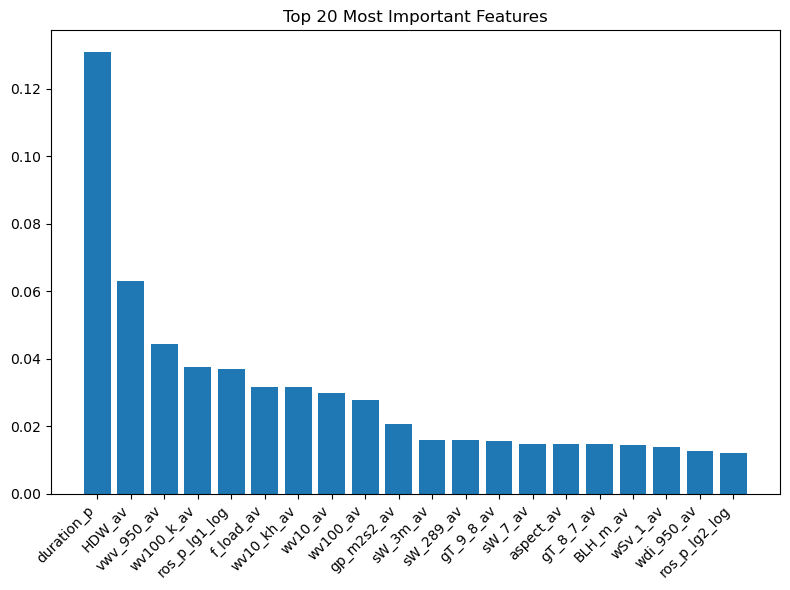


Top 20 Most Important Features:
          feature  importance
0      duration_p    0.130810
37         HDW_av    0.063076
83     vwv_950_av    0.044414
28     wv100_k_av    0.037681
94  ros_p_lg1_log    0.037004
8       f_load_av    0.031748
26     wv10_kh_av    0.031540
88        wv10_av    0.029899
89       wv100_av    0.027873
22     gp_m2s2_av    0.020804
34       sW_3m_av    0.015992
21      sW_289_av    0.015837
48      gT_9_8_av    0.015687
18        sW_7_av    0.014856
5       aspect_av    0.014842
49      gT_8_7_av    0.014686
15       BLH_m_av    0.014568
45       wSv_1_av    0.013798
78     wdi_950_av    0.012596
95  ros_p_lg2_log    0.012258


In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(importances['feature'][:20], importances['importance'][:20])
plt.xticks(rotation=45, ha='right')
plt.title(f'Top 20 Most Important Features')
plt.tight_layout()
plt.show()

print("\nTop 20 Most Important Features:")
print(importances.head(20))

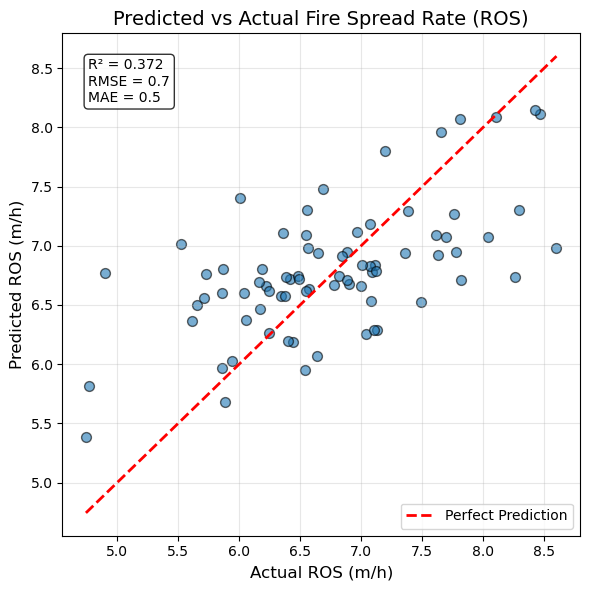

In [ ]:
# Predicted vs Actual scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test_log, y_pred_log, alpha=0.6, edgecolor='k', s=50)

# Perfect prediction line
min_val = min(y_test_log.min(), y_pred_log.min())
max_val = max(y_test_log.max(), y_pred_log.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title('Predicted vs Actual Fire Spread Rate (ROS)', fontsize=14)
plt.xlabel('Actual ROS (m/h)', fontsize=12)
plt.ylabel('Predicted ROS (m/h)', fontsize=12)

# Add metrics annotation
plt.text(0.05, 0.95, f'R² = {r2:.3f}\nRMSE = {rmse:.1f}\nMAE = {mae:.1f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# 1. Create a small DataFrame with actual vs predicted
sample_df = pd.DataFrame({
    'Actual': y_test_final,
    'Predicted': y_pred
}).reset_index(drop=True)

# 2. Randomly sample 10 rows
sample_10 = sample_df.sample(10).copy()

# 3. Compute % error (symmetric MAPE-style for clarity)
sample_10['% Error'] = ((sample_10['Predicted'] - sample_10['Actual']) / sample_10['Actual']) * 100

# 4. Format nicely
sample_10['% Error'] = sample_10['% Error'].round(2)

# 5. Display
print("Sample of 10 predictions vs actual values:\n")
display(sample_10)

Sample of 10 predictions vs actual values:



,Actual,Predicted,% Error
19,627.920784,485.352163,-22.70
75,350.827361,734.764012,109.44
58,599.456399,489.239854,-18.39
76,248.834806,1113.126831,347.34
23,353.536611,897.006336,153.72
70,1329.737935,2433.869074,83.03
20,512.490381,525.635747,2.56
10,993.934835,794.038868,-20.11
64,418.704089,735.162769,75.58
34,486.982211,902.352447,85.29


Exception ignored in: <function ResourceTracker.__del__ at 0x103269bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107a19bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1075f1bc0>
Traceback (most recent call last

### XGBoost model

### Use linear scale

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 200
max_resources_: 2000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 200
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_forest.py", line 375, in fit
    estimator._co

----------
iter: 1
n_candidates: 4
n_resources: 600
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [ 0.19515706  0.20740187  0.20532034         nan         nan  0.10204048
 -0.45970763  0.19394687         nan         nan  0.19643376  0.19741048
  0.20145106  0.20751299]
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the train scores are non-finite: [0.65107553 0.59904251 0.5820555         nan        nan 0.77692827
 0.90241996 0.53611221        nan        nan 0.53775118 0.65550641
 0.58178088 0.59685218]
  warnings.warn(


----------
iter: 2
n_candidates: 2
n_resources: 1800
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [ 0.19515706  0.20740187  0.20532034         nan         nan  0.10204048
 -0.45970763  0.19394687         nan         nan  0.19643376  0.19741048
  0.20145106  0.20751299  0.20064436  0.19777753]
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the train scores are non-finite: [0.65107553 0.59904251 0.5820555         nan        nan 0.77692827
 0.90241996 0.53611221        nan        nan 0.53775118 0.65550641
 0.58178088 0.59685218 0.58172576 0.59726805]
  warnings.warn(



Search complete.
Best parameters found: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 150, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 9, 'n_estimators': 1800}

Linear scale metrics:
R2 Score: 0.3017
RMSE: 934.1481
MAE: 652.7465


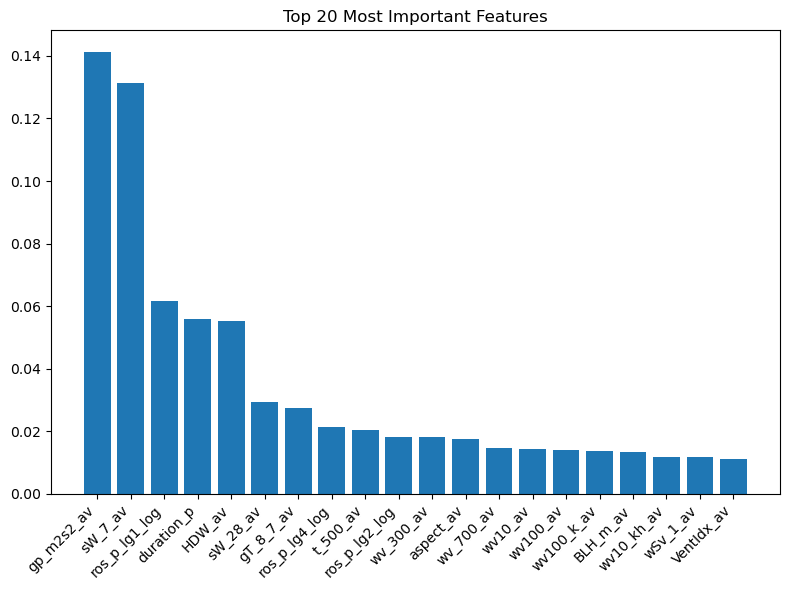


Top 20 Most Important Features:
          feature  importance
0      gp_m2s2_av    0.141113
1         sW_7_av    0.131442
2   ros_p_lg1_log    0.061787
3      duration_p    0.055843
4          HDW_av    0.055131
5        sW_28_av    0.029531
6       gT_8_7_av    0.027472
7   ros_p_lg4_log    0.021489
8        t_500_av    0.020553
9   ros_p_lg2_log    0.018281
10      wv_300_av    0.018093
11      aspect_av    0.017479
12      wv_700_av    0.014601
13        wv10_av    0.014253
14       wv100_av    0.013929
15     wv100_k_av    0.013563
16       BLH_m_av    0.013496
17     wv10_kh_av    0.011932
18       wSv_1_av    0.011928
19     VentIdx_av    0.011105


In [ ]:
# -----------------------------------------
# 1. Use linear targets (no log transformation)
# -----------------------------------------
y_train_linear = y_train_final.copy()
y_test_linear = y_test_final.copy()

# -----------------------------------------
# 2. Hyperparameter distribution
# -----------------------------------------
param_dist = {
    'max_depth': [None, 20, 50, 100, 150],        # allow deeper trees
    'min_samples_split': randint(2, 20),          # explore more splits
    'min_samples_leaf': randint(1, 10),           # test smaller and larger leaves
    'max_features': ['sqrt', 'log2', 0.5, 0.8, None],  # let it use a larger subset
    'bootstrap': [True, False],                   # allow testing both sampling methods
    'criterion': ['squared_error', 'absolute_error'],  # MSE vs MAE split criteria
}

# 3. Set up RandomizedSearchCV
# Initialize the base model
base_model = RandomForestRegressor(n_jobs=-1) #random_state=42

tscv = TimeSeriesSplit(n_splits=5)

rf_random = HalvingRandomSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    factor=3,       # how aggressively to cut poor performers
    resource='n_estimators',
    max_resources=2000,
    min_resources=200,
    scoring='r2',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

rf_random.fit(X_train_final, y_train_linear)

# -----------------------------------------
# 4. Get best model and predictions
# -----------------------------------------
print(f"\nSearch complete.")
print(f"Best parameters found: {rf_random.best_params_}")
best_model = rf_random.best_estimator_

y_pred_linear = best_model.predict(X_test_final)

# -----------------------------------------
# 5. Calculate metrics on linear scale
# -----------------------------------------
r2_linear = r2_score(y_test_linear, y_pred_linear)
rmse_linear = np.sqrt(mean_squared_error(y_test_linear, y_pred_linear))
mae_linear = mean_absolute_error(y_test_linear, y_pred_linear)

print("\nLinear scale metrics:")
print(f"R2 Score: {r2_linear:.4f}")
print(f"RMSE: {rmse_linear:.4f}")
print(f"MAE: {mae_linear:.4f}")

# -----------------------------------------
# 6. Feature importances
# -----------------------------------------
feature_names = X_train_final.columns.tolist()

importances = pd.DataFrame({
    'feature': feature_names,
    'importance': best_model.feature_importances_
})

importances = importances.sort_values(by='importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(8, 6))
plt.bar(importances['feature'][:20], importances['importance'][:20])
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

print("\nTop 20 Most Important Features:")
print(importances.head(20))

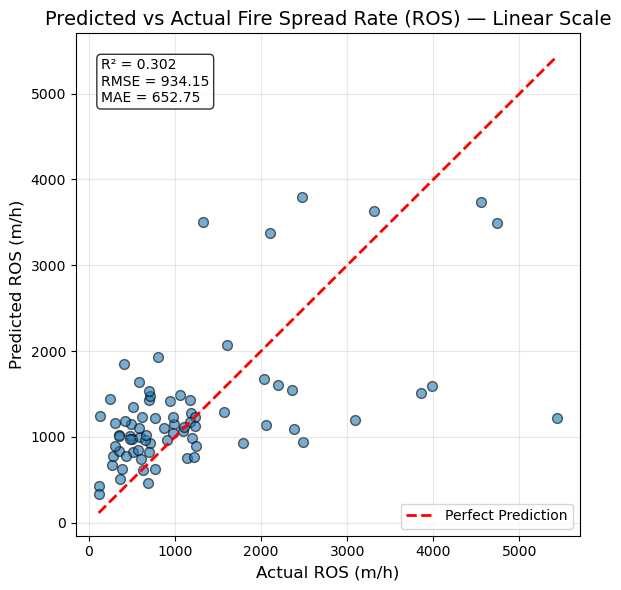

In [ ]:
# Predicted vs Actual scatter plot for new linear-target model
plt.figure(figsize=(6, 6))
plt.scatter(y_test_linear, y_pred_linear, alpha=0.6, edgecolor='k', s=50)

# Perfect prediction line
min_val = min(y_test_linear.min(), y_pred_linear.min())
max_val = max(y_test_linear.max(), y_pred_linear.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title('Predicted vs Actual Fire Spread Rate (ROS) — Linear Scale', fontsize=14)
plt.xlabel('Actual ROS (m/h)', fontsize=12)
plt.ylabel('Predicted ROS (m/h)', fontsize=12)

# Add metrics annotation (linear-scale metrics)
plt.text(0.05, 0.95, f'R² = {r2_linear:.3f}\nRMSE = {rmse_linear:.2f}\nMAE = {mae_linear:.2f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# 1. Create a small DataFrame with actual vs predicted (linear model)
sample_df = pd.DataFrame({
    'Actual': y_test_linear,
    'Predicted': y_pred_linear
}).reset_index(drop=True)

# 2. Randomly sample 10 rows
sample_10 = sample_df.sample(10).copy()

# 3. Compute % error
sample_10['% Error'] = ((sample_10['Predicted'] - sample_10['Actual']) / sample_10['Actual']) * 100

# 4. Format nicely
sample_10['% Error'] = sample_10['% Error'].round(2)

# 5. Display
print("Sample of 10 predictions vs actual values (linear model):\n")
display(sample_10)

Sample of 10 predictions vs actual values (linear model):



,Actual,Predicted,% Error
42,2106.494615,3375.006334,60.22
45,3315.753935,3635.842485,9.65
23,353.536611,1019.259082,188.30
39,1604.084633,2068.397006,28.95
65,3091.766468,1196.286725,-61.31
5,405.390325,1854.686251,357.51
15,1569.342228,1294.909048,-17.49
53,1221.834330,762.146939,-37.62
27,273.618239,668.281253,144.24
72,578.546288,1643.757052,184.12
